In [1]:
# Autoencoder SelfieDS
# Miguelangel Moreno Sotelo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
import time
import pickle
import keras
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras import optimizers
from keras import losses
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

from PIL import Image,ImageOps

Using TensorFlow backend.


## DataSet

In [2]:
class DataSet:
    data_train = None;
    data_test  = None;
    
    # 30935 total
    total_train = 28152;
    total_test  =  2783;
       
    
    def read_pickle(self, name, show=False):
        
        if show:
            print('Cargando pickle',"../DataSet/{}.pickle".format(name));
        pic = pickle.load(open("../DataSet/{}.pickle".format(name), "rb"));
        
        X = np.array(pic['X']);   
        Y = np.array(pic['Y']);
        
        if show:
           print('X-',X.shape)
           print('Y-',Y.shape)        
                
        return X,Y;
                         
        
    def load_dataset(self):
        self.data_train = dict(X=[],Y=[]);
        self.data_test  = dict(X=[],Y=[]);
        
        for i in range(1,4):
            x,y = self.read_pickle('train_clselfie_v3_{}'.format(i), show=True);
            self.data_train['X'].extend(x);
            self.data_train['Y'].extend(y);
        
        x,y = self.read_pickle('test_clselfie_v3', show=True);
        self.data_test['X'].extend(x);
        self.data_test['Y'].extend(y);
           
        
        new = [];
        for i,x in enumerate(self.data_train['X']):
            #plt.imshow(x);
            #plt.show();            
            
            image = Image.fromarray(x)  

            # Fit a la imagen
            img_dim = (208,208);
            image = ImageOps.fit(image,(img_dim[0],img_dim[1]),Image.ANTIALIAS,centering=(0.5, 0.5));
#             image = image.convert('P')
            image = image.convert('L')
            image = np.array(image).reshape(img_dim[1],img_dim[0],1)
            
            new.append(image);
            
#             plt.imshow(image,cmap='gray');
#             plt.show();
#             print(image)
#             break;
            
                
        self.data_train['X'] = np.array(new);
        
        new = [];
        for i,x in enumerate(self.data_test['X']):
            image = Image.fromarray(x)     

            # Fit a la imagen
            img_dim = (208,208);
            image = ImageOps.fit(image,(img_dim[0],img_dim[1]),Image.ANTIALIAS,centering=(0.5, 0.5));
            image = image.convert('L')
            image = np.array(image).reshape(img_dim[1],img_dim[0],1)
            
            new.append(image);
            
            #plt.imshow(image);
            #plt.show();            
                
        self.data_test['X'] = np.array(new);
        
        
        new = [];
        for i,x in enumerate(self.data_test['Y']):
            bf = np.array(x);
            new.append(bf);
        self.data_test['Y'] = np.array(new);
        
        new = [];
        for i,x in enumerate(self.data_train['Y']):
            bf = np.array(x);
            new.append(bf);
        self.data_train['Y'] = np.array(new);
        
        
        print('\nTotal Train Data X:',self.data_train['X'].shape,'Y:',self.data_train['Y'].shape);
        print('\nTotal Test  Data X:',self.data_test['X'].shape,'Y:',self.data_test['Y'].shape);    
        
        

        

In [3]:
# Cargamos Dataset
ds = DataSet();
ds.load_dataset();

Cargando pickle ../DataSet/train_clselfie_v3_1.pickle
X- (9000, 200, 200, 3)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v3_2.pickle
X- (9000, 200, 200, 3)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v3_3.pickle
X- (10152, 200, 200, 3)
Y- (10152, 5)
Cargando pickle ../DataSet/test_clselfie_v3.pickle
X- (2783, 200, 200, 3)
Y- (2783, 5)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)

Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)


Y [0.72222222 0.60194175 0.57943925 0.50549451 0.59375   ]


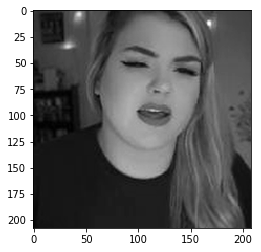

Y [0.66666667 0.51456311 0.44859813 0.65934066 0.54166667]


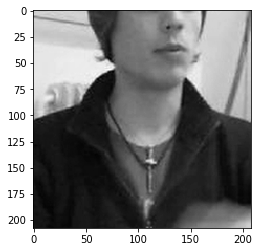

Y [0.52222222 0.5631068  0.42056075 0.45054945 0.58333333]


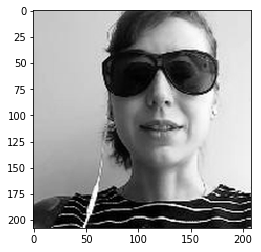

Y [0.66666667 0.39805825 0.58878505 0.42857143 0.70833333]


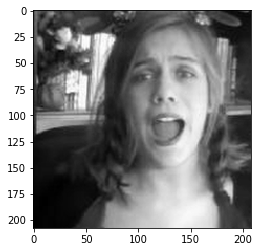

In [4]:
for i in range(0,2):
    print('Y',ds.data_test['Y'][i])
    plt.imshow(ds.data_test['X'][i].reshape(208,208), cmap='gray')
    plt.show();
    
for i in range(0,2):
    print('Y',ds.data_train['Y'][i])
    plt.imshow(ds.data_train['X'][i].reshape(208,208), cmap='gray')
    plt.show();

# Cargo Modelo Autoencoder

In [5]:
name = 'acoder_train_1'
json_file = open('{}.json'.format(name), 'r')
loaded_model_json = json_file.read()
print(loaded_model_json)
json_file.close()
autoencoder = model_from_json(loaded_model_json)

{"class_name": "Model", "config": {"name": "model_7", "layers": [{"name": "input_7", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 208, 208, 1], "dtype": "float32", "sparse": false, "name": "input_7"}, "inbound_nodes": []}, {"name": "conv2d_37", "class_name": "Conv2D", "config": {"name": "conv2d_37", "trainable": true, "filters": 4, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_7", 0, 0, {}]]]}, {"name": "max_pooling2d_19", "class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_19", "tra

In [6]:
autoencoder.load_weights("{}.h5".format(name))
print("Modelo cargado desde disco ")
autoencoder.summary();

Modelo cargado desde disco 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 208, 208, 4)       40        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 104, 104, 4)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 104, 104, 8)       296       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 52, 52, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 52, 52, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 26, 26, 16) 

# Pruebo el autoencoder con imagenes ChaLearn

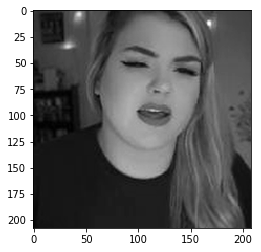

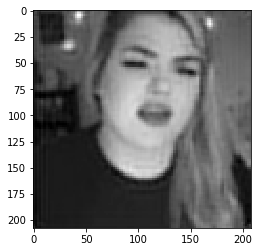

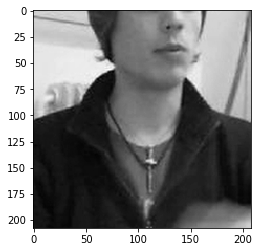

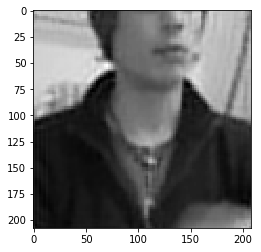

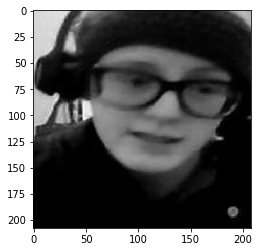

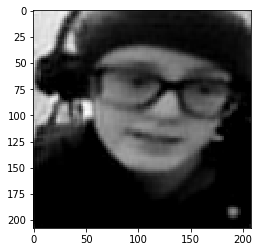

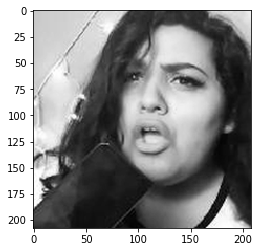

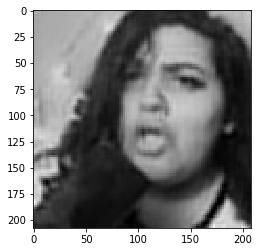

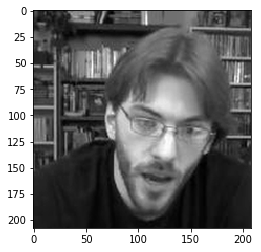

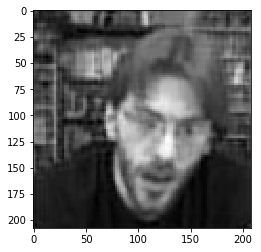

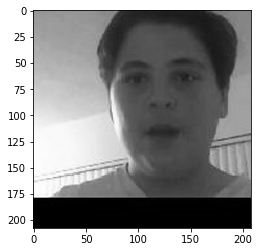

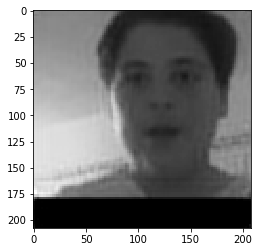

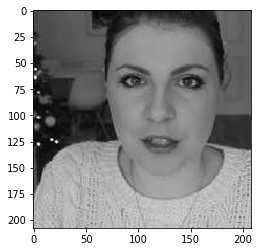

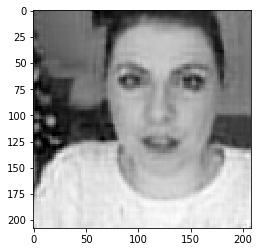

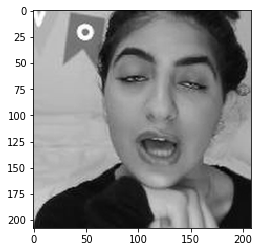

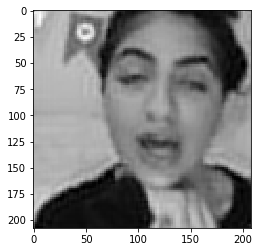

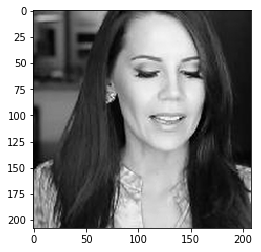

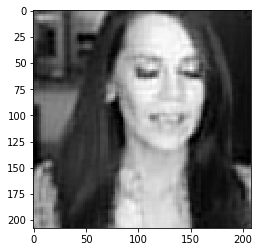

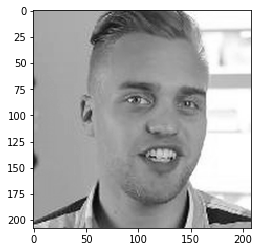

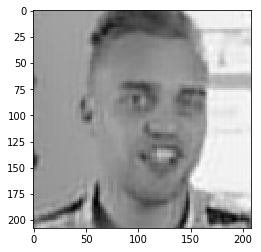

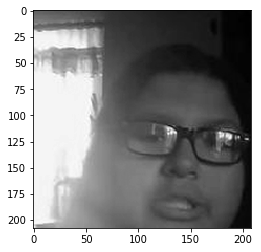

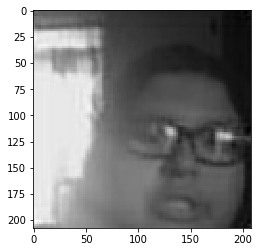

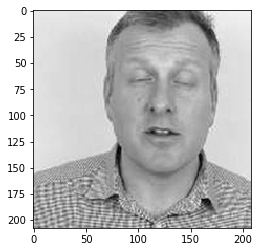

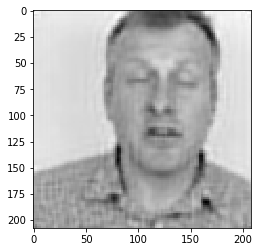

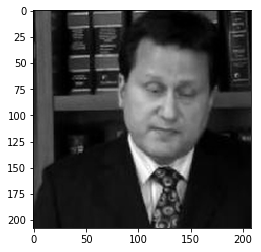

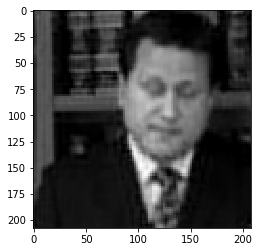

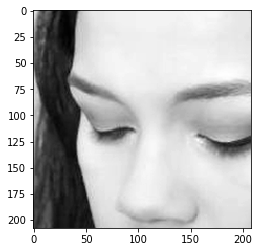

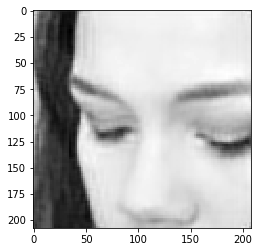

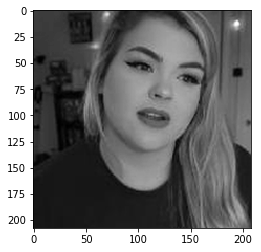

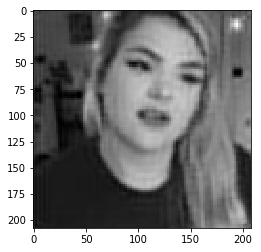

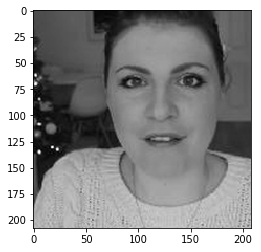

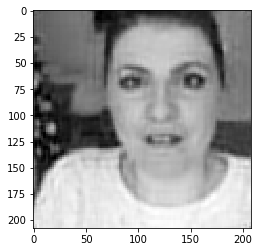

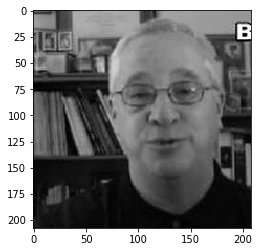

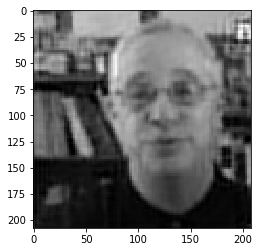

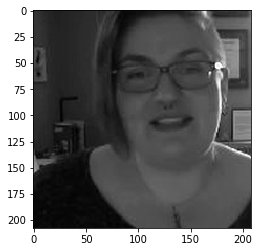

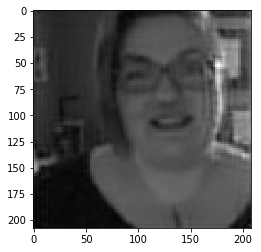

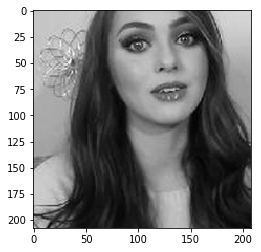

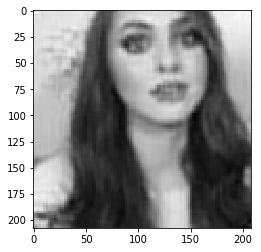

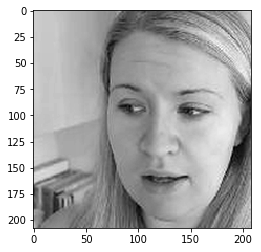

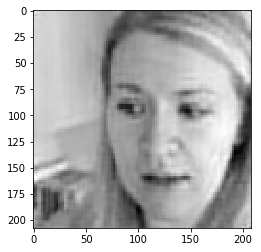

(208, 208, 1)


In [7]:
# Plot
x_test = ds.data_test['X'][0:20];
x_recon = autoencoder.predict(x_test)

for i in range(len(x_test)):
    plt.imshow(x_test[i].reshape(208,208), cmap='gray');
    plt.show();
    
    plt.imshow(x_recon[i].reshape(208,208), cmap='gray');
    plt.show();

print(x_recon[0].shape)

## Extraigo embeding del autoencoder para ChaLearn

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 208, 208, 4)       40        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 104, 104, 4)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 104, 104, 8)       296       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 52, 52, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 52, 52, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 26, 26, 16)        0         
__________

In [9]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_21').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 208, 208, 4)       40        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 104, 104, 4)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 104, 104, 8)       296       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 52, 52, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 52, 52, 16)        1168      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 26, 26, 16)        0         
Total para

In [10]:
embeding_train = encoder.predict(ds.data_train['X']); 
embeding_test  = encoder.predict(ds.data_test['X']); 

print('Embedings Train',embeding_train.shape)
print('Embedings Test',embeding_test.shape)

Embedings Train (28152, 26, 26, 16)
Embedings Test (2783, 26, 26, 16)


In [11]:
# Si es necesario, aplanamos
embeding_train = embeding_train.reshape(-1,26*26*8) 
embeding_test  = embeding_test.reshape(-1,26*26*8) 

print('Embedings Train',embeding_train.shape)
print('Embedings Test',embeding_test.shape)

Embedings Train (28152, 5408)
Embedings Test (2783, 5408)


## Modelo Complementario y Entrenamiento

In [57]:
input_cla = Input(shape=(26,26,16,))
# input_cla = Input(shape=(26*26*8,))

fmap = 16;
x = Conv2D(fmap, (3,3), activation='relu', padding='same')(input_cla)
x = MaxPooling2D((2, 2), padding='same')(x)

fmap = 16;
x = Conv2D(fmap, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


img_dim = math.ceil(26/(2**2))

x = Reshape((img_dim*img_dim*fmap,),input_shape=(img_dim,img_dim,fmap))(x)
x=Dense(500,activation='relu', input_shape=(img_dim*img_dim*fmap,))(x)
x=Dense(500,activation='relu')(x)
x=Dense(100,activation='relu')(x)

output=Dense(5,)(x)


adam = optimizers.adam(lr=1e-6)
classifier = Model(input_cla, output)
classifier.compile(optimizer=adam, loss=losses.mean_squared_error)


In [12]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
__________

In [36]:
def save_model(index=0):
    model_json = autoencoder.to_json()
    with open("acoder_sup_train_{}.json".format(index), "w") as json_file:
        json_file.write(model_json)
    classifier.save_weights("acoder_sup_train_{}.h5".format(index),)
    print("Modelo guardado en disco","acoder_sup_train_{}.h5".format(index))

In [37]:
save = 1;

In [58]:
global_history = {'val_loss':[], 'loss':[], 'mean_acc':[]}
best_acc = 0;

In [78]:
for i in range(0,400):
    h = classifier.fit(embeding_train, ds.data_train['Y'],
                epochs=1,
                batch_size=100,
                shuffle=False,
                validation_data=(embeding_test, ds.data_test['Y']))
    
    global_history['val_loss'].extend(h.history['val_loss'])
    global_history['loss'].extend(h.history['loss'])
    
    mean_acc = get_global_evaluation();
    global_history['mean_acc'].append(mean_acc);
    
    print('Mean-acc:',mean_acc)
    
    if mean_acc > best_acc:
        best_acc = mean_acc;
        save_model(index=save);

Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 51us/step - loss: 0.0179 - val_loss: 0.0202
Mean-acc: 88.46290195455599
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0179 - val_loss: 0.0202
Mean-acc: 88.46332927126622
Modelo guardado en disco acoder_sup_train_1.h5
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0179 - val_loss: 0.0202
Mean-acc: 88.4631983674984
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0179 - val_loss: 0.0202
Mean-acc: 88.46340262205132
Modelo guardado en disco acoder_sup_train_1.h5
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0179 - val_loss: 0.0202
Mean-acc: 88.46368407946743
Mo

Mean-acc: 88.46812551319219
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 49us/step - loss: 0.0177 - val_loss: 0.0202
Mean-acc: 88.46859191775249
Modelo guardado en disco acoder_sup_train_1.h5
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 49us/step - loss: 0.0177 - val_loss: 0.0202
Mean-acc: 88.46851436518646
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 49us/step - loss: 0.0177 - val_loss: 0.0202
Mean-acc: 88.46840506606803
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 49us/step - loss: 0.0177 - val_loss: 0.0202
Mean-acc: 88.46841040372561
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 48us/step - loss: 0.0177 - val_loss: 0.0202
Mean-acc: 88.46834879182765
Train on 28152 sampl

28152/28152 [==============================] - 1s 47us/step - loss: 0.0175 - val_loss: 0.0202
Mean-acc: 88.47264221453864
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 48us/step - loss: 0.0175 - val_loss: 0.0202
Mean-acc: 88.47242913072618
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 2s 54us/step - loss: 0.0175 - val_loss: 0.0202
Mean-acc: 88.47278087132047
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0175 - val_loss: 0.0202
Mean-acc: 88.47255614214775
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0175 - val_loss: 0.0202
Mean-acc: 88.4727270638235
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0175 - val_loss: 0.0202
Me

28152/28152 [==============================] - 1s 47us/step - loss: 0.0171 - val_loss: 0.0203
Mean-acc: 88.47218363574022
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0171 - val_loss: 0.0203
Mean-acc: 88.47218199254718
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 2s 55us/step - loss: 0.0171 - val_loss: 0.0203
Mean-acc: 88.47187805412733
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 51us/step - loss: 0.0171 - val_loss: 0.0203
Mean-acc: 88.47197981615423
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 51us/step - loss: 0.0171 - val_loss: 0.0203
Mean-acc: 88.47219696031155
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0171 - val_loss: 0.0203
M

28152/28152 [==============================] - 2s 56us/step - loss: 0.0168 - val_loss: 0.0203
Mean-acc: 88.46643008446729
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 52us/step - loss: 0.0167 - val_loss: 0.0203
Mean-acc: 88.46668758027923
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 48us/step - loss: 0.0167 - val_loss: 0.0203
Mean-acc: 88.46634712939058
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 48us/step - loss: 0.0167 - val_loss: 0.0203
Mean-acc: 88.4665790497289
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 51us/step - loss: 0.0167 - val_loss: 0.0203
Mean-acc: 88.46664593990332
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 52us/step - loss: 0.0167 - val_loss: 0.0203
Me

28152/28152 [==============================] - 1s 47us/step - loss: 0.0164 - val_loss: 0.0204
Mean-acc: 88.45534308071993
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 49us/step - loss: 0.0164 - val_loss: 0.0204
Mean-acc: 88.45548463542892
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0164 - val_loss: 0.0204
Mean-acc: 88.45529337892114
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0164 - val_loss: 0.0204
Mean-acc: 88.45461102260232
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0164 - val_loss: 0.0204
Mean-acc: 88.45448387911885
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 1s 47us/step - loss: 0.0163 - val_loss: 0.0204
M

In [79]:
classifier.load_weights("acoder_sup_train_1.h5")
print("Modelo cargado desde disco ")

Modelo cargado desde disco 


In [80]:
print(max(global_history['mean_acc']))

88.47537945721798


In [81]:
print(global_history['mean_acc'])

[-73.44506373930915, -47.8669012445356, -31.52010876104447, -19.42559755392751, -10.12302283079634, -2.420300840456746, 3.9641910050553038, 9.389267716461813, 14.158077101653078, 18.38966587321986, 22.258070674839537, 25.776138709865506, 28.948771767644303, 31.78819670165391, 34.451902105349234, 36.95621230181705, 39.40407729319226, 41.72516300646391, 43.94127929411586, 46.05049399273363, 47.92330829896756, 49.71040571582, 51.382539760022645, 52.93522405343085, 54.448361712401514, 55.92733087733022, 57.352873552472715, 58.70360209782872, 60.03057613036342, 61.304373281896346, 62.52870865598707, 63.71198622048348, 64.84281546839073, 65.93828419962826, 66.97754486591195, 67.96863106820432, 68.91502930758172, 69.80025689774973, 70.62589602159396, 71.43626227330628, 72.21658144649845, 72.9820741791232, 73.71049575380523, 74.39214304422484, 75.0519782807633, 75.65981335578417, 76.24055479855436, 76.80782724753243, 77.3462007076528, 77.86263664572341, 78.36145521418791, 78.84292064050508, 79

In [82]:
print(global_history['loss'])

[13.120792501316249, 4.175530638739479, 3.248473295436457, 2.644731699692048, 2.2182486444483023, 1.8984788027328672, 1.6480446497667036, 1.4520437457101458, 1.2947949339260123, 1.1636885606148393, 1.051714745722023, 0.9557007097002118, 0.872190807473087, 0.7990353524295333, 0.7339520661219103, 0.6754554103521097, 0.6220034032374087, 0.5728852540830484, 0.5282927136058393, 0.48803497831839737, 0.45251760979662836, 0.42126293011215066, 0.3932016137421013, 0.36772912080974257, 0.34430277678278165, 0.3225325373665417, 0.30222464546150496, 0.28343631843759715, 0.2658830287337777, 0.2494627366598847, 0.23421550305620042, 0.21999966655096975, 0.20669683963737898, 0.19427115804483755, 0.18268938602058682, 0.17205446928477008, 0.16216070886725695, 0.15296508039952036, 0.14456373670157738, 0.13679568636892497, 0.12949518833767795, 0.12259035200117731, 0.11604221092452885, 0.10990864546182448, 0.10414818335249364, 0.09880640745294234, 0.09387446120254321, 0.08925396365328721, 0.0849846491569499,

In [83]:
print(global_history['val_loss'])

[4.815263989243283, 3.557540034716651, 2.834707741595154, 2.3458563875389578, 1.9963221707619911, 1.7299091430863502, 1.5212853197737901, 1.3542720570308975, 1.2155858213593966, 1.097200605923265, 0.9942422865364905, 0.9062679890373222, 0.830916562484744, 0.7661277625657568, 0.7076733568311808, 0.6542284160134949, 0.6044166192835371, 0.5583688043408629, 0.5161029614221694, 0.47781586248669916, 0.4444326327787729, 0.41440767000529394, 0.3875269319485984, 0.3630469321369311, 0.34031619787473194, 0.3190602735247151, 0.2992257109508213, 0.2810192986482174, 0.2633792671675824, 0.2467939584665576, 0.23114246819094708, 0.2165174577954087, 0.2031364775029524, 0.19093051204739653, 0.17977173439020566, 0.1694887616556838, 0.15990915972146463, 0.15106452413055907, 0.14295134434501258, 0.1352525774149898, 0.1279057519623499, 0.12087458018728867, 0.11437347108860303, 0.10831492143089806, 0.10261197766724825, 0.09752778129058479, 0.0927795711027989, 0.08835402553806705, 0.08426671295265821, 0.080390

In [88]:
%matplotlib inline
epoch_graph = 1000;

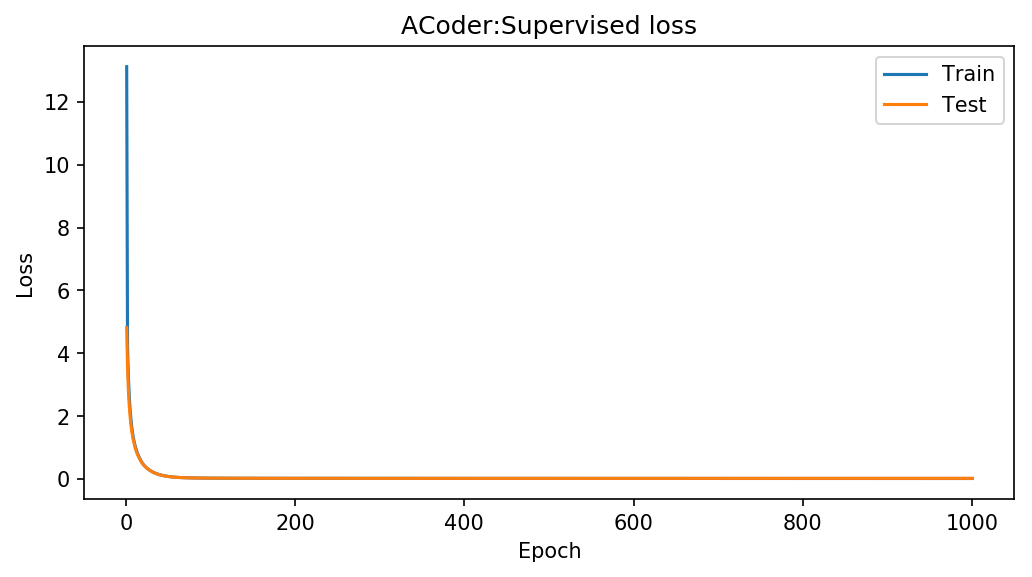

In [89]:
# Plot training & validation loss values
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)
x = np.arange(1,epoch_graph+1,1);

axes.plot(x, global_history['loss'][0:epoch_graph+1])
axes.plot(x, global_history['val_loss'][0:epoch_graph+1])

plt.title('ACoder:Supervised loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')


fig.savefig("acoder_sup-full.png",dpi=150) 

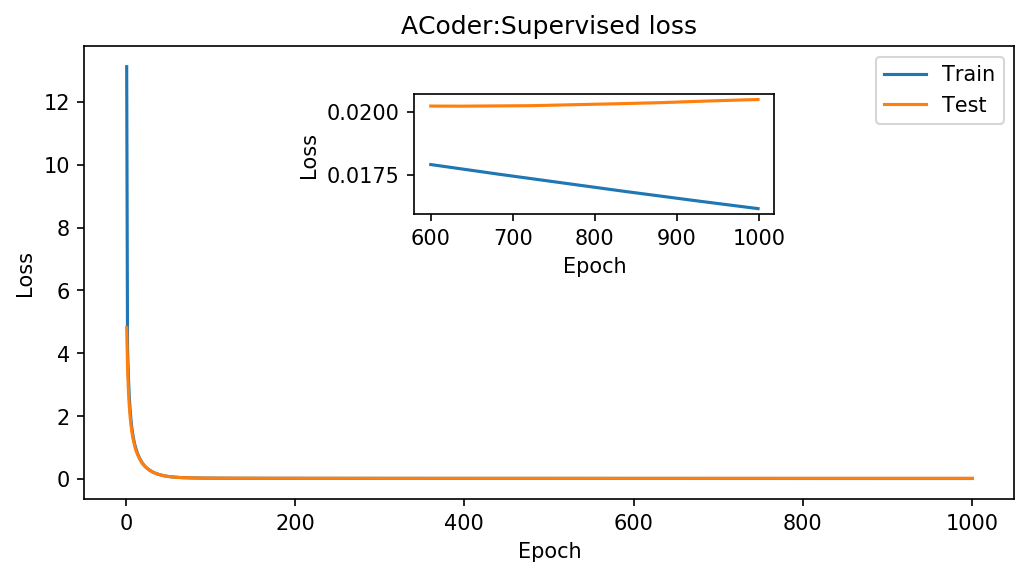

In [92]:
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,epoch_graph+1,1);
axes.plot(x, global_history['loss'][0:epoch_graph+1])
axes.plot(x, global_history['val_loss'][0:epoch_graph+1])
plt.title('ACoder:Supervised loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

zoom_init = 600;
zoom_end = 1000;
x = np.arange(zoom_init,zoom_end,1);
axes2=fig.add_axes([0.4,0.6,0.3,0.2])
axes2.plot(x, global_history['loss'][zoom_init:zoom_end])
axes2.plot(x, global_history['val_loss'][zoom_init:zoom_end])
axes2.set_xlabel("Epoch")
axes2.set_ylabel("Loss")

fig.savefig("acoder_sup-mix.png",dpi=150) 

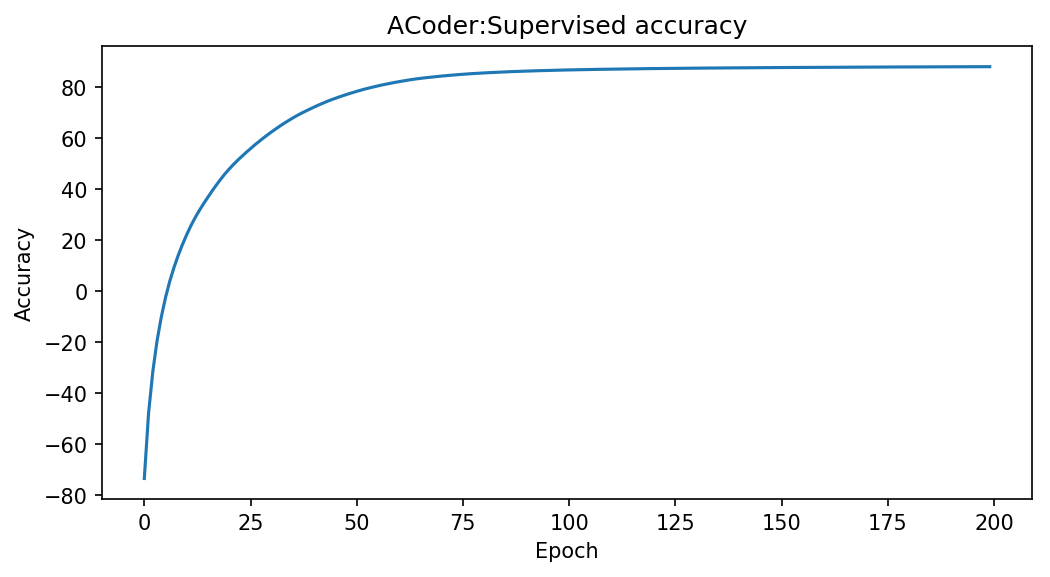

In [93]:
# Plot ACC
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,epoch_graph+1,1);
axes.plot(global_history['mean_acc'][0:200])
plt.title('ACoder:Supervised accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


fig.savefig("acoder_sup-acc.png",dpi=150) 

In [94]:
def test_regresor_per_factor(index=0, show=False):
    # Test como regresor
    tolerance_i = 0.1;
    X = embeding_test;
    Y = ds.data_test['Y'];
    out = classifier.predict(X)

    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):         
        diff = diff + (1 - abs(Y[i][index]-out[i][index]));

    acc = diff / (out.shape[0] * 1);
    acc = acc *100;
    
    if show:
        print('Acc CL',acc);
    acc1 = acc;


    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):  
        diff = abs(Y[i][index]-out[i][index]); 

        if diff<=tolerance_i:
            acc = acc + 1;

    acc = acc / (out.shape[0] * 1);
    acc = acc *100;

    if show:
        print('Acc uno tol',acc);   
    
    return (acc1,acc);

def get_global_evaluation(show=False):

    prom_cl = 0;
    prom_to = 0;
    
    if show:
        print('O');
    (a1,a2) = test_regresor_per_factor(index=0, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nC');
    (a1,a2) = test_regresor_per_factor(index=1, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nE');
    (a1,a2) = test_regresor_per_factor(index=2, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nA');
    (a1,a2) = test_regresor_per_factor(index=3, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nN');
    (a1,a2) = test_regresor_per_factor(index=4, show=show);
    prom_cl += a1;
    prom_to += a2;

    prom_cl = prom_cl/5;
    prom_to = prom_to/5;

    if show:
        print('\nPromedio');
        print('ChaLearn',prom_cl)
        print('Uno tol', prom_to)
        
    return prom_cl;

get_global_evaluation(show=True)

O
Acc CL 89.05882159326272
Acc uno tol 51.70679123248293

C
Acc CL 87.43215896524633
Acc uno tol 45.59827524254402

E
Acc CL 88.24410864678482
Acc uno tol 49.73050664750269

A
Acc CL 89.45547110679989
Acc uno tol 53.39561624146605

N
Acc CL 88.18633697399612
Acc uno tol 49.838303988501615

Promedio
ChaLearn 88.47537945721798
Uno tol 50.053898670499464


88.47537945721798

In [95]:
# Test como clasificacion binaria
def test_factor_class(index=0):
    X = embeding_test;
    Y = ds.data_test['Y'];
    out = classifier.predict(X)
    
    limit = 0.5714; # 4/7
#     limit = 0.5;
    
    acc = 0;

    for i in range(out.shape[0]): 
        if Y[i][index]>limit and out[i][index]>limit:
            acc = acc + 1;
        elif Y[i][index]<=limit and out[i][index]<=limit:
            acc = acc + 1;

    acc = acc / out.shape[0];
    acc *= 100;
    
    return acc;

def get_global_acc(show=False):

    acc_global = 0;

    acc = test_factor_class(index=0);
    acc_global += acc;
    if show:
        print('O',acc);   

    acc = test_factor_class(index=1);
    acc_global += acc;
    if show:
        print('C',acc);    

    acc = test_factor_class(index=2);
    acc_global += acc;
    if show:
        print('E',acc);  

    acc = test_factor_class(index=3);
    acc_global += acc;
    if show:
        print('A',acc);    

    acc = test_factor_class(index=4);
    acc_global += acc;
    if show:
        print('N',acc);  

    acc_global = acc_global / 5;
    if show:
        print('\nPromedio',acc_global)
        
    return acc_global;

prom = get_global_acc(show=True);
# print(prom)

O 61.26482213438735
C 64.46280991735537
E 70.21200143729787
A 56.449874236435505
N 61.98347107438017

Promedio 62.87459575997126
